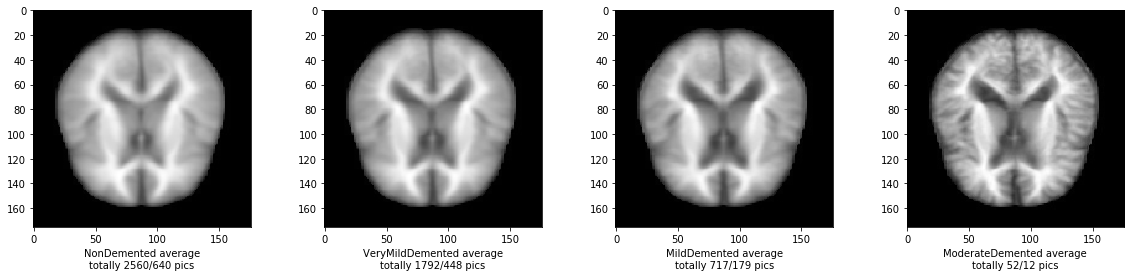

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image

TRAIN_DIR = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/'
TEST_DIR = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/'
IMAGE_SIZE = 176
CLASSES = [
    'NonDemented',
    'VeryMildDemented',
    'MildDemented',
    'ModerateDemented',
]
train_images = {}
test_images = {}

for klass in CLASSES:
    train_images[klass] = []
    test_images[klass] = []

for klass in CLASSES:
    for image in os.listdir(TRAIN_DIR + klass):
        im = Image.open(TRAIN_DIR + klass + '/' + image).convert('L')
        train_images[klass].append(im.resize((IMAGE_SIZE, IMAGE_SIZE)))
        
    for image in os.listdir(TEST_DIR + klass):
        im = Image.open(TEST_DIR + klass + '/' + image).convert('L')
        test_images[klass].append(im.resize((IMAGE_SIZE, IMAGE_SIZE)))

from matplotlib import pyplot as plt

plt.figure(1, figsize=(20, 4))
i = 1
for klass in CLASSES:
    avg_pic = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
    for pic in train_images[klass] + test_images[klass]:
        avg_pic += np.array(pic)
    avg_pic = avg_pic / (len(train_images[klass]) + len(test_images[klass]))
    plt.subplot(1, 4, i)
    i += 1
    plt.imshow(avg_pic, cmap='gray')
    plt.xlabel('%s average\ntotally %d/%d pics' % (klass, len(train_images[klass]), len(test_images[klass])))
plt.show()

In [2]:
class_weight = {}
max_classes = len(test_images['NonDemented']) / 100
for i, klass in enumerate(CLASSES):
    class_weight[i] = max_classes / len(test_images[klass])
class_weight

{0: 0.01,
 1: 0.014285714285714287,
 2: 0.03575418994413408,
 3: 0.5333333333333333}

In [3]:
from keras.utils import np_utils
from skimage.exposure import equalize_adapthist as eq_hist

def equalize(im):
    return eq_hist(np.array(im), clip_limit=0.03)

train_data = np.array([equalize(i) for i in train_images[CLASSES[0]]])
train_labels = np.zeros((len(train_images[CLASSES[0]]), 1))
for ind, klass in enumerate(CLASSES[1:], start=1):
    klass_arr = np.array([equalize(i) for i in train_images[klass]])
    train_data = np.concatenate([train_data, klass_arr], axis=0)
    
    labels_arr = np.ones((len(train_images[klass]), 1)) * ind
    train_labels = np.concatenate([train_labels, labels_arr], axis=0)

test_data = np.array([equalize(i) for i in test_images[CLASSES[0]]])
test_labels = np.zeros((len(test_images[CLASSES[0]]), 1))
for ind, klass in enumerate(CLASSES[1:], start=1):
    klass_arr = np.array([equalize(i) for i in test_images[klass]])
    test_data = np.concatenate([test_data, klass_arr], axis=0)
    
    labels_arr = np.ones((len(test_images[klass]), 1)) * ind
    test_labels = np.concatenate([test_labels, labels_arr], axis=0)

    
train_data = train_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
test_data = test_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))

train_labels = np_utils.to_categorical(train_labels)
test_labels = np_utils.to_categorical(test_labels)

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

Using TensorFlow backend.


((5121, 176, 176, 1), (5121, 4), (1279, 176, 176, 1), (1279, 4))

In [4]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

p = np.random.permutation(train_data.shape[0])
train_data = train_data[p]
train_labels = train_labels[p]

ros = RandomOverSampler(random_state=42)
train_ros_data, train_ros_labels = ros.fit_resample(train_data.reshape((-1, IMAGE_SIZE * IMAGE_SIZE)), train_labels)
test_ros_data, test_ros_labels = ros.fit_resample(test_data.reshape((-1, IMAGE_SIZE * IMAGE_SIZE)), test_labels)

train_ros_data = train_ros_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))
test_ros_data = test_ros_data.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1))

train_ros_data.shape, train_ros_labels.shape, test_ros_data.shape, test_ros_labels.shape

((10240, 176, 176, 1), (10240, 4), (2560, 176, 176, 1), (2560, 4))

In [5]:
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import Adam

imagegen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=15,
    height_shift_range=15,
    zoom_range=0.2
)

def create_cnn(filters=[32], kernels=[3, 3, 5], dropout=0.5, denses=[128], reg=.0001):

    model = Sequential()
    
    for i, fil in enumerate(filters):
        if i == 0:
            model.add(Conv2D(fil, kernels[0], activation='elu', padding='same', kernel_regularizer=l2(reg), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
        else:
            model.add(Conv2D(fil, kernels[0], activation='elu', padding='same', kernel_regularizer=l2(reg)))
        
        for ker in kernels[1:]:
            model.add(BatchNormalization())
            model.add(Conv2D(fil, ker, activation='elu', padding='same', kernel_regularizer=l2(reg)))
            
        model.add(MaxPooling2D())
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Flatten())
    
    for den in denses:
        model.add(Dense(den, activation='elu', kernel_regularizer=l2(reg)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    
    model.add(Dense(len(CLASSES), activation='softmax'))
    
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(.001),
        metrics=['acc']
    )

    return model